In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from transformers import AddTime, LeadLag
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score
from scipy.io import arff
import torch
import time 
import iisignature
from tools import *
from sigKer_numpy import *

In [18]:
data_train = arff.loadarff('Multivariate2018_arff/Multivariate_arff/ArticularyWordRecognition/ArticularyWordRecognition_TRAIN.arff')
data_test = arff.loadarff('Multivariate2018_arff/Multivariate_arff/ArticularyWordRecognition/ArticularyWordRecognition_TEST.arff')

df_train = pd.DataFrame(data_train[0]).iloc[::5,:]
df_test = pd.DataFrame(data_test[0]).iloc[::5,:]

labels_train = df_train.iloc[:,1]
labels_test = df_test.iloc[:,1]

y_train = LabelEncoder().fit_transform(labels_train)
y_test = LabelEncoder().fit_transform(labels_test)

x_train = [np.array(a.tolist()).T for a in df_train.iloc[:,0]]
x_test = [np.array(a.tolist()).T for a in df_test.iloc[:,0]]

In [19]:
df_train.head()

,relationalAtt,classAttribute
0,"[[0.87159, 0.88042, 0.88042, 0.81962, 0.81962,...",b'1.0'
5,"[[0.91615, 0.91615, 1.3847, 1.3847, 1.1836, 1....",b'1.0'
10,"[[1.2156, 1.2386, 1.2386, 0.76401, 0.76401, 0....",b'1.0'
15,"[[1.4873, 0.94752, 1.1426, 1.5621, 1.5621, 1.4...",b'2.0'
20,"[[1.6719, 2.2542, 2.1522, 2.1522, 2.8073, 2.74...",b'2.0'


In [33]:
def transform(paths):
    paths = LeadLag().fit_transform(paths)
#     paths = AddTime().fit_transform(paths)
#     derivatives = [np.diff(p,axis=0) for p in paths]
#     derivatives = [d/d.max() for d in derivatives]
#     paths = [d.cumsum(0) for d in derivatives]
#     return [p/p.max() for p in paths]
    return paths

In [34]:
scale = 0.1
x_train = scale*np.array(transform(x_train))
x_test = scale*np.array(transform(x_test))
l = x_train.shape[1]

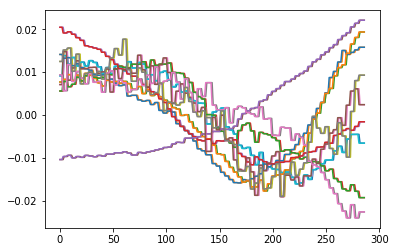

In [35]:
plt.plot(x_train[1])
plt.show()

In [36]:
x_train.shape

(55, 287, 18)

In [37]:
x_test.shape

(60, 287, 18)

In [38]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [39]:
n = 0

In [ ]:
gram_matrix = sig_covariance(x_train, x_train, n)

In [ ]:
test_matrix = sig_covariance(x_train, x_test, n)

In [ ]:
results_penalty = []
for p in np.linspace(0.01, 2000, 50):
    clf = SVC(C=p, kernel='precomputed', decision_function_shape='ovo', gamma='auto')
    clf.fit(gram_matrix, y_train)
    predictions = clf.predict(test_matrix)
    results_penalty.append(accuracy_score(predictions, y_test))

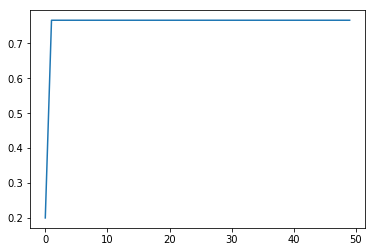

In [30]:
plt.plot(results_penalty)

In [31]:
final_results = {}

# standard kernels
for ker in ['linear', 'poly', 'rbf']:
    clf = SVC(C=2000, kernel=ker, decision_function_shape='ovo', gamma='auto')
    clf.fit([c.reshape(-1) for c in x_train], y_train)
    predictions = clf.predict([c.reshape(-1) for c in x_test])
    final_results[ker] = accuracy_score(predictions, y_test)
    
# signature naive kernel
clf = SVC(C=2000, kernel='linear', decision_function_shape='ovo', gamma='auto')
clf.fit([iisignature.sig(c,4) for c in x_train], y_train)
predictions = clf.predict([iisignature.sig(c,4) for c in x_test])
final_results['sig-naive'] = accuracy_score(predictions, y_test)

final_results['sig-PDE'] = max(results_penalty)

In [32]:
pd.DataFrame.from_dict(final_results, orient='index').rename(columns={0:'accuracy (%)'})

,accuracy (%)
linear,0.900000
poly,0.250000
rbf,0.900000
sig-naive,0.733333
sig-PDE,0.766667
